# Lab 1: Serving a Model with vLLM

This section is to walk through how to serve a open source model using vLLM (the upstream project of Red Hat AI Inference Server.

### What is an Inference Server?
An inference server is the piece of software that allows artificial intelligence (AI) applications to communicate with large language models (LLMs) and generate a response based on data. This process is called inference. It’s where the business value happens and the end result is delivered.

### How does Red Hat AI Inference Server work?
Red Hat AI Inference Server provides fast and cost-effective inference at scale. Its open source nature allows it to support any generative AI (gen AI) model, on any AI accelerator, in any cloud environment. 

Powered by [vLLM](https://docs.vllm.ai/en/latest/), the inference server maximizes GPU utilization, and enables faster response times. Combined with LLM Compressor capabilities, inference efficiency increases without sacrificing performance. With cross-platform adaptability and a growing community of contributors, vLLM is emerging as the Linux® of gen AI inference. 

### Red Hat AI Repository
The Red Hat AI repository on Hugging Face is an open-source initiative backed by deep collaboration between IBM and Red Hat’s research, engineering, and business units. We’re committed to making AI more accessible, efficient, and community-driven from research to production.

We believe the future of AI is open. That’s why we’re sharing our latest models and research on Hugging Face, which are freely available to help researchers, developers, and organizations deploy high-performance AI at scale.

Here's the link to Red Hat AI Repository - https://huggingface.co/RedHatAI

### Now, let's start with serving an open source model using the upstream vLLM library.

Double check the right version of vllm has been installed successfully.

In [1]:
!pip install vllm==0.9.1 -q


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


---
# Start the vLLM server

## Quick commands:
* To Serve a model, you can run the command `vllm serve` from a terminal.  
* To view all of the vLLM the options type the following into a terminal: `vllm serve -h`.

For this lab we will serve the validated model `Llama-3.2-1B-Instruct-FP8` from Red Hat AI Repository on Hugging Face. To view the model details open a new browser tab and paste the following url into the address: `https://huggingface.co/RedHatAI/Llama-3.2-1B-Instruct-FP8.

## Serve the model
This part of the lab requires you to work in a terminal. To open a new terminal window:  
1. Click **File > New > Terminal** in the JupyterLab toolbar.
   JupyterLab opens a new tab with a bash terminal session.

2. Click the terminal's tab and drag it to the right side of the screen.
   JupyterLab docks the terminal to the right of this notebook.

3. Highlight the following text: `vllm serve RedHatAI/Llama-3.2-1B-Instruct-FP8 --port 8000 --tensor-parallel-size 1`  
5. With the text highlightd, type **Ctrl+C** to copy the command to the clipboard.
6. In the Terminal window, right-click.
   JupyterLab displays the copy/paste popup menu.

7. Click **Paste**.
   The command is pasted into the terminal window. Validate it is correct and make ay necessary corrections.

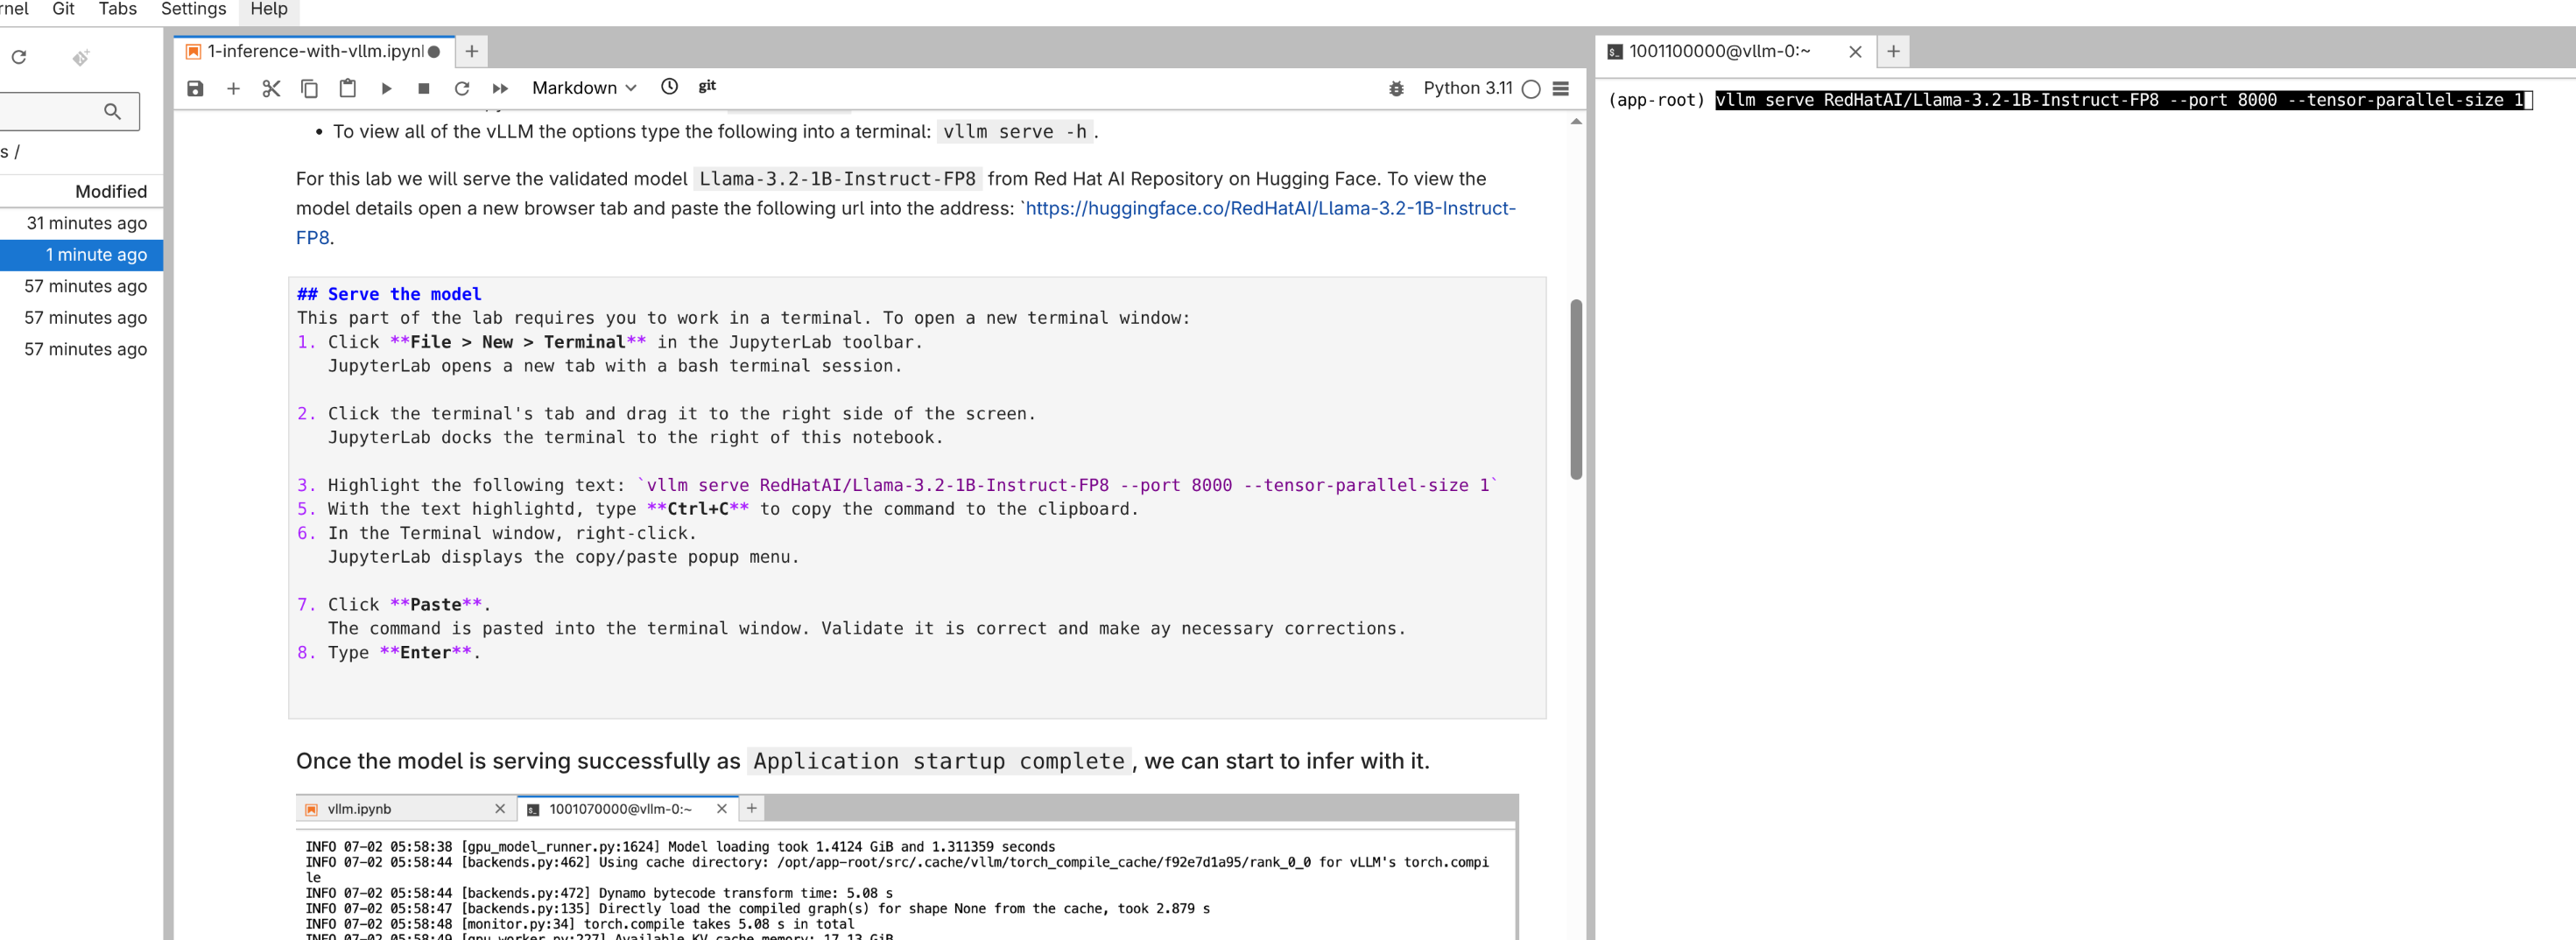
   
9. Type **Enter**.  
   Wait for the model server to start.  


Once the model is serving successfully as `Application startup complete`, we can start to infer with it.
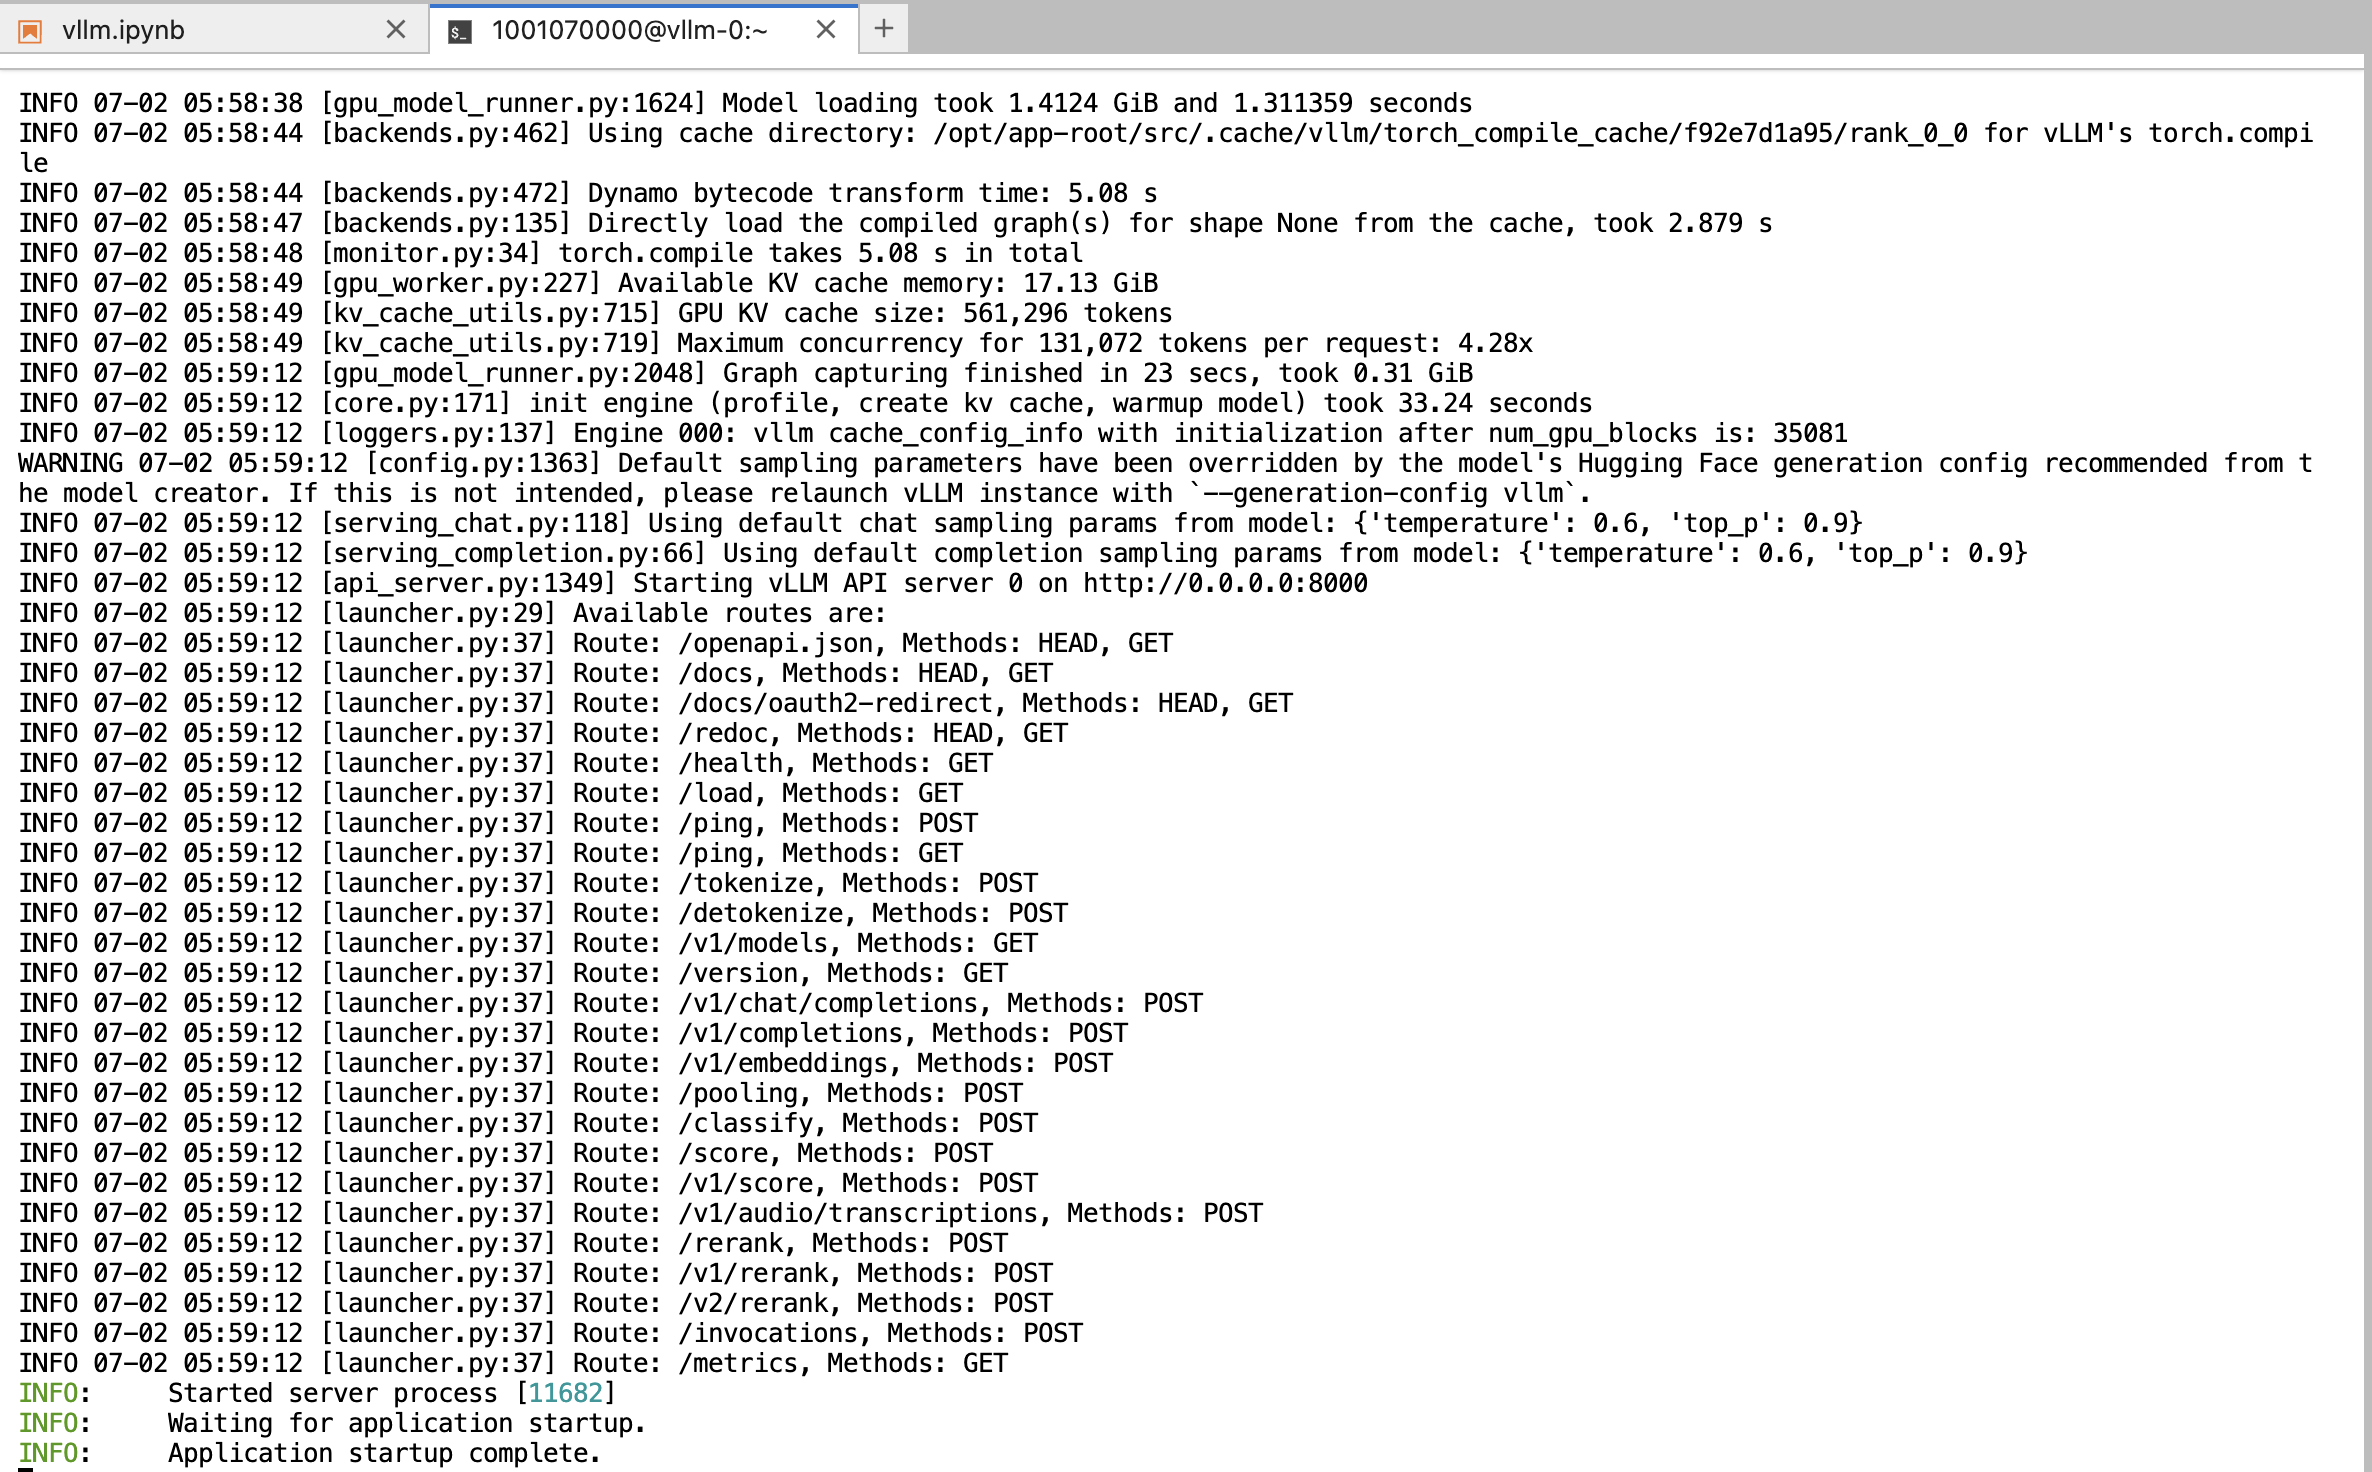

---
We can use Curl to test out the endpoint http://localhost:8000.
##### vLLM provides an HTTP server that implements ***OpenAI's Completions API, Chat API, and more!*** This functionality lets you serve models and interact with them using an HTTP client.

In [5]:
!curl -X POST -H "Content-Type: application/json" -d '{ \
    "prompt": "What is the capital of France?", \
    "max_tokens": 50 \
}' http://localhost:8000/v1/completions

{"id":"cmpl-2ef57a49371a45c49578ef31fa67e234","object":"text_completion","created":1752113704,"model":"RedHatAI/Llama-3.2-1B-Instruct-FP8","choices":[{"index":0,"text":" Paris.\nThe capital of France is indeed Paris. It is the most famous city in France and is known for its iconic landmarks such as the Eiffel Tower, Notre-Dame Cathedral, and the Louvre Museum.\n\nParis is a city that has","logprobs":null,"finish_reason":"length","stop_reason":null,"prompt_logprobs":null}],"usage":{"prompt_tokens":8,"total_tokens":58,"completion_tokens":50,"prompt_tokens_details":null},"kv_transfer_params":null}

As you can see above, you've got the response from the model serving!

#### Model Serving Key Metrics

Use the following metrics to evaluate the performance of the LLM model being served with AI Inference Server:

- ***Time to first token (TTFT)***: How long does it take for the model to provide the first token of its response?
- ***Time per output token (TPOT)***: How long does it take for the model to provide an output token to each user, who has sent a request?
- ***Latency***: How long does it take for the model to generate a complete response?
- ***Throughput***: How many output tokens can a model produce simultaneously, across all users and requests?

Now, let's use benchmark test agaist vLLM. \
We will need some additional pypl packages - pandas, dataset.  Double check if those packages are installed.

In [6]:
!pip install pandas datasets -q


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


Then we need clone the vllm git repo, and use the `benchmark_serving.py`.

In [7]:
!git clone https://github.com/vllm-project/vllm.git

Cloning into 'vllm'...
remote: Enumerating objects: 88858, done.
remote: Counting objects: 100% (252/252), done.
remote: Compressing objects: 100% (207/207), done.
remote: Total 88858 (delta 135), reused 45 (delta 45), pack-reused 88606 (from 3)
Receiving objects: 100% (88858/88858), 62.02 MiB | 31.60 MiB/s, done.
Resolving deltas: 100% (69891/69891), done.


Now we run the following command to do the benchmark performance testing.

In [1]:
!python vllm/benchmarks/benchmark_serving.py \
--backend vllm --model RedHatAI/Llama-3.2-1B-Instruct-FP8 \
--num-prompts 100 --dataset-name random  --random-input 200 --random-output 200 --port 8000

INFO 07-02 23:53:27 [__init__.py:244] Automatically detected platform cuda.
Namespace(backend='vllm', base_url=None, host='127.0.0.1', port=8000, endpoint='/v1/completions', dataset_name='random', dataset_path=None, max_concurrency=None, model='RedHatAI/Llama-3.2-1B-Instruct-FP8', tokenizer=None, use_beam_search=False, num_prompts=100, logprobs=None, request_rate=inf, burstiness=1.0, seed=0, trust_remote_code=False, disable_tqdm=False, profile=False, save_result=False, save_detailed=False, append_result=False, metadata=None, result_dir=None, result_filename=None, ignore_eos=False, percentile_metrics='ttft,tpot,itl', metric_percentiles='99', goodput=None, custom_output_len=256, custom_skip_chat_template=False, sonnet_input_len=550, sonnet_output_len=150, sonnet_prefix_len=200, sharegpt_output_len=None, random_input_len=200, random_output_len=200, random_range_ratio=0.0, random_prefix_len=0, hf_subset=None, hf_split=None, hf_output_len=None, top_p=None, top_k=None, min_p=None, temperatur

You may need use Huggingface Token to pull the model for the test above. \
`!export HF_TOKEN=hf_xxxx` \
Or, use `huggingface-cli login`

---
It will be very interesting to commpare the benchmark results with published results, such as NVIDIA NIM serving benchmark at https://docs.nvidia.com/nim/benchmarking/llm/latest/performance.html#llama-3-1-8b-instruct-results.
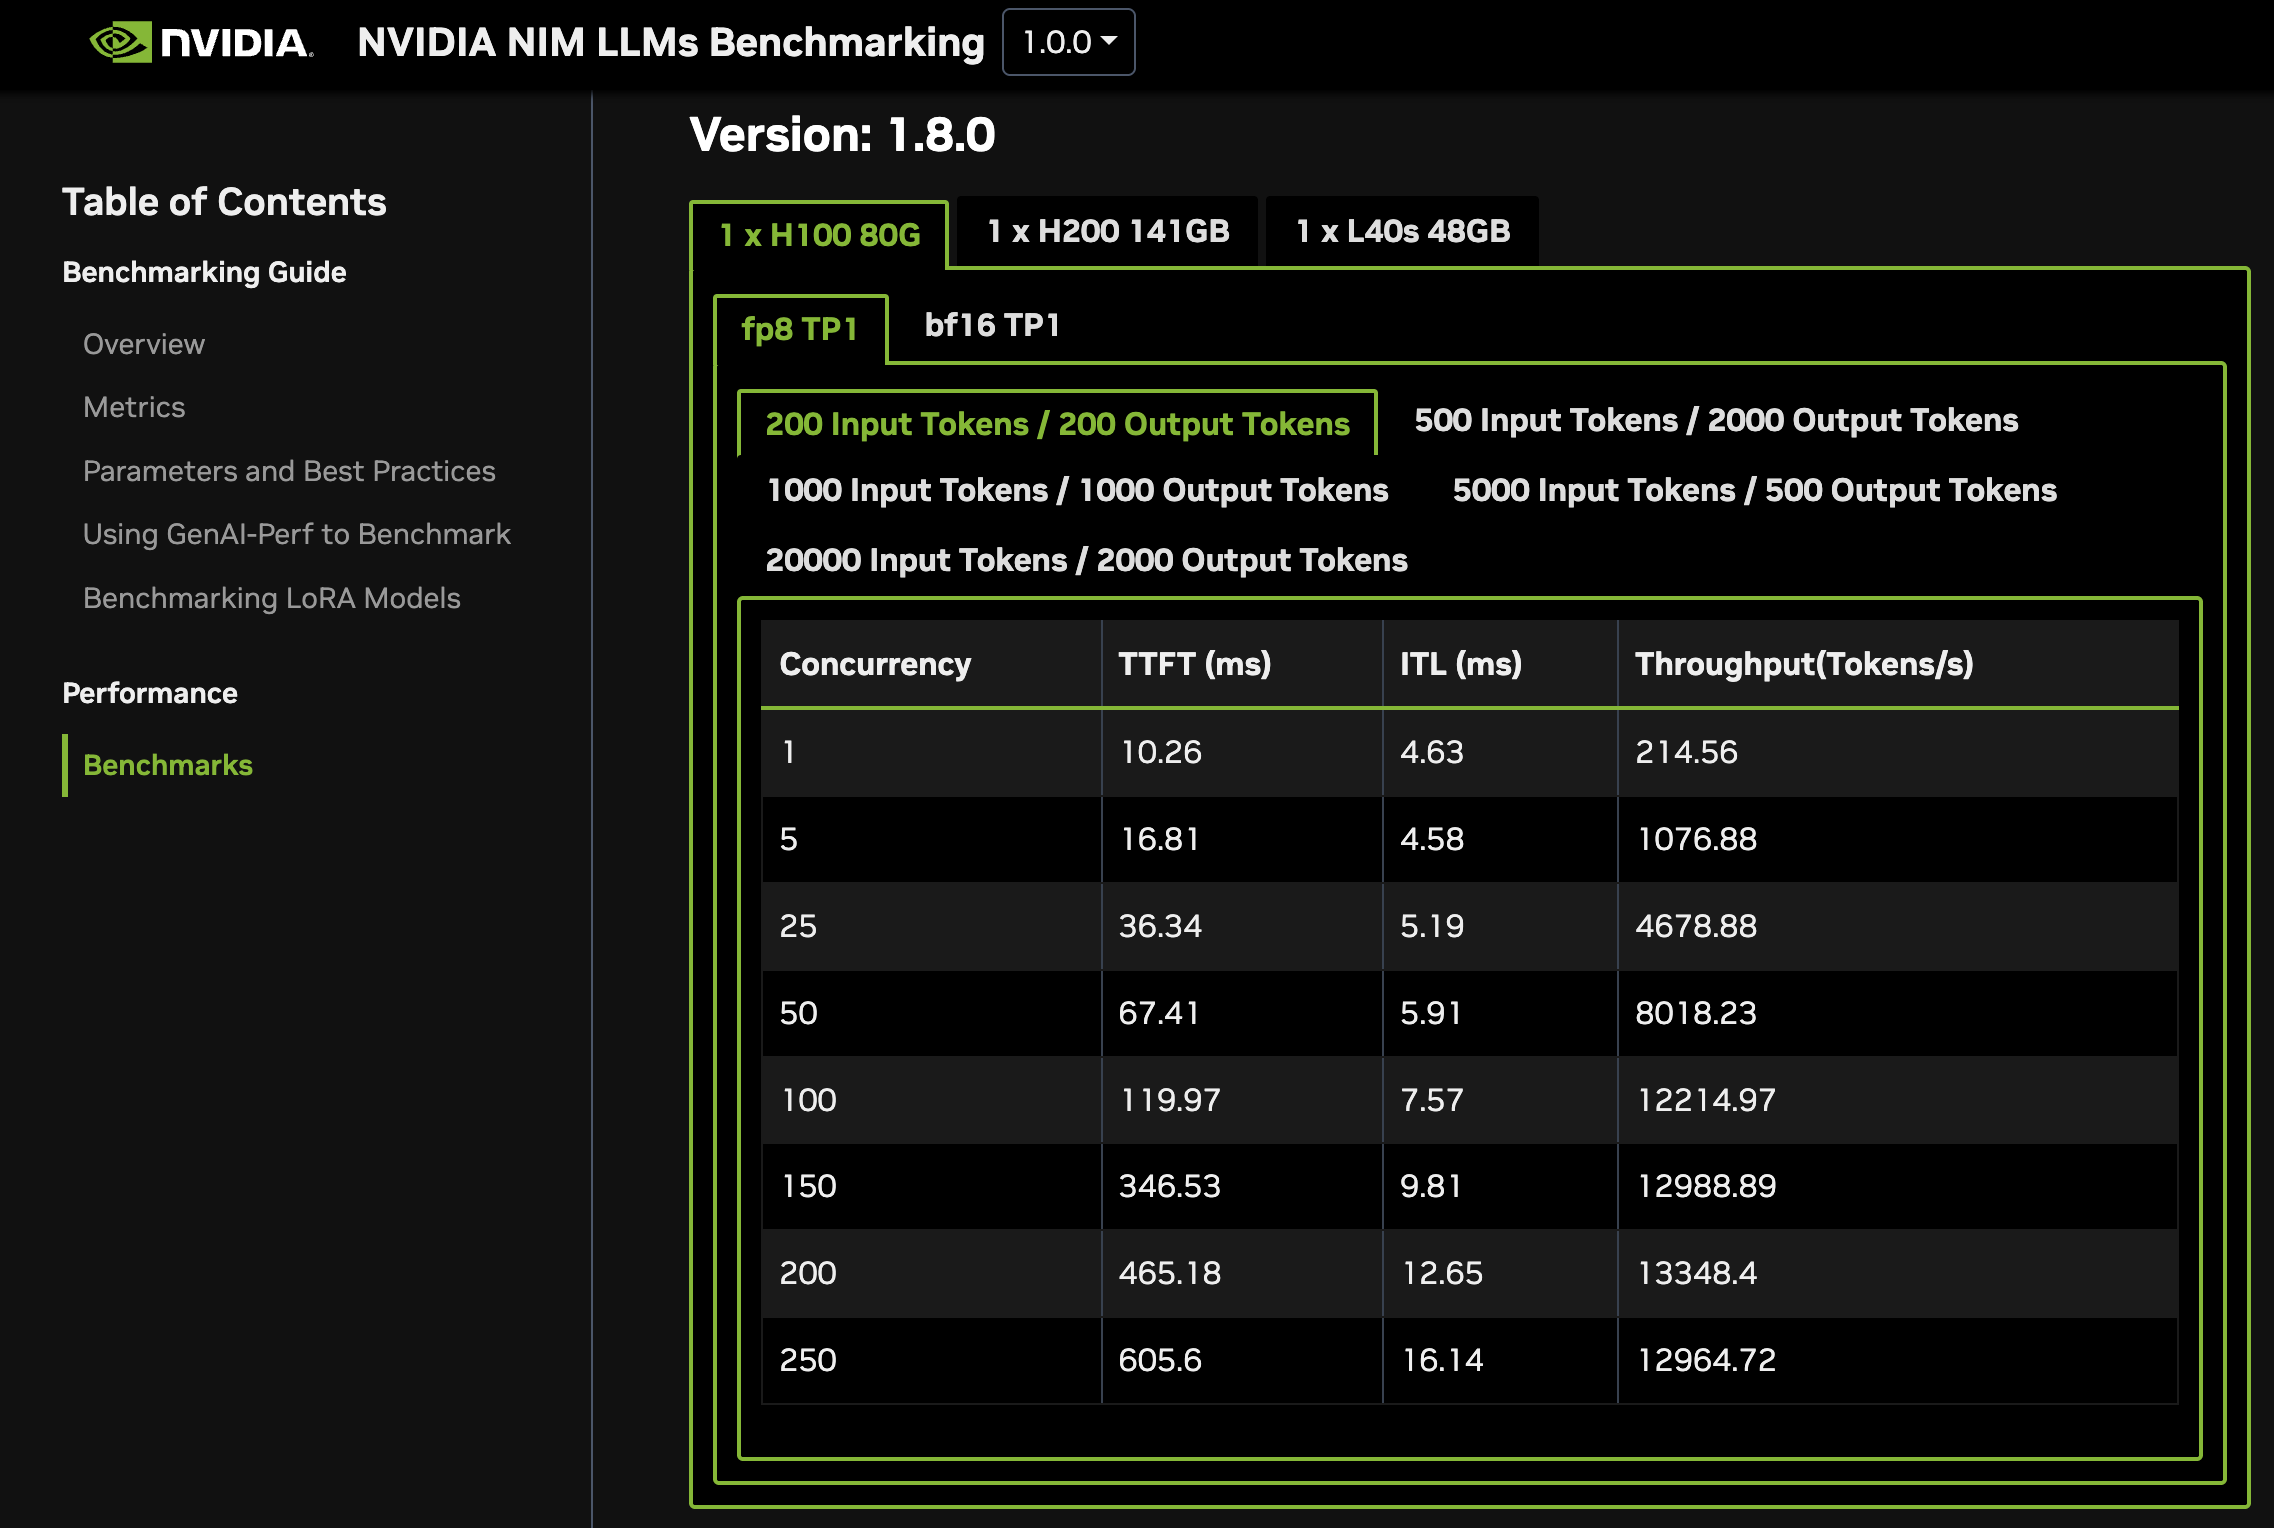

In [8]:
from IPython.display import IFrame

IFrame("https://docs.nvidia.com/nim/benchmarking/llm/latest/performance.html#llama-3-1-8b-instruct-results", width=600, height=600)

---
#### Explanations of performance benchmark

First, let's check what GPU we're using in the lab. We will need to log into the pod to check the GPU info.

Copy the login command from the web console.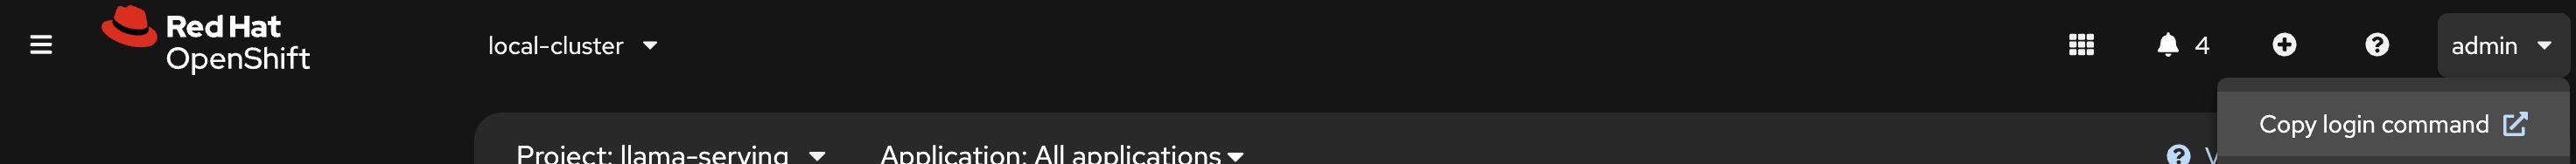 
Run the command as below

In [26]:
!oc login -u admin -p ${ADMIN_PASSWORD} --server=https://api.sno.${BASE_DOMAIN}:6443

Logged into "https://api.sno.sandbox631.opentlc.com:6443" as "admin" using the token provided.

You have access to 108 projects, the list has been suppressed. You can list all projects with 'oc projects'

Using project "vllm-demo".


List all the pods and find the name of the pod that our workbench sits in.

In [28]:
!oc get pods -n vllm-demo

NAME     READY   STATUS    RESTARTS   AGE
vllm-0   2/2     Running   0          46h


Exec into the pod `vllm-0` and run the command `nvidia-smi`

In [29]:
!oc exec vllm-0 -- nvidia-smi

Defaulted container "vllm" out of: vllm, oauth-proxy
Wed Jul  2 23:26:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.148.08             Driver Version: 570.148.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      On  |   00000000:36:00.0 Off |                    0 |
| N/A   50C    P0             34W /   72W |   20888MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N

We can see we are using a **shared L4 GPU** with only **24GB** memory.

Now, let's compare the results with Nvidia NIM benchamark test.
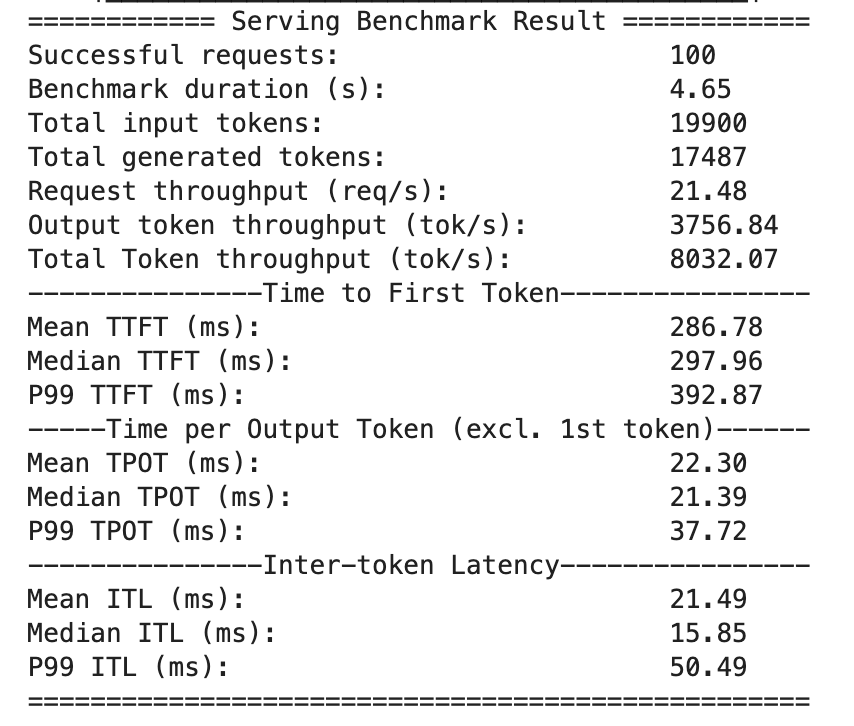

By comparing with H100 served by Nvidia NIM performance benchmark, here's some highlights of vllm's performance data.

|   Metrics             |   vLLM with L4 GPU |   NIM with H100 GPU  |
|-----------------------|--------------------|----------------------|
| GPU Memory            |        24 GiB      |        80 GiB        |
| FP16                  |      ~120 TFLops   |      ~500-700 TFlops |
| INT8                  |      ~240 Tops     |       ~2000 Tops     |
| Mem. Bandwidth        |       300 GB/s     |     Up to 3.35 TB/s  |
|-----------------------|--------------------|----------------------|
| Mean TTFT (S)         |        0.29        |         0.12         |
| Mean ITL (S)          |        0.22        |         0.07         |
| Throughput (tokens/s) |       8,032.07      |      12,214.97        |
|-----------------------|--------------------|----------------------|
| Approx. Unit Price($) |        2,000       |       25,000         |

We are using ***~10x*** cheapter GPU with vLLM serving a similar size of LLama3.2 model, and we have delivered nearly **50%** performance.

---
#### 📌  Once you have done this lab, please remember stop the vLLM serving from the terminal.📌 

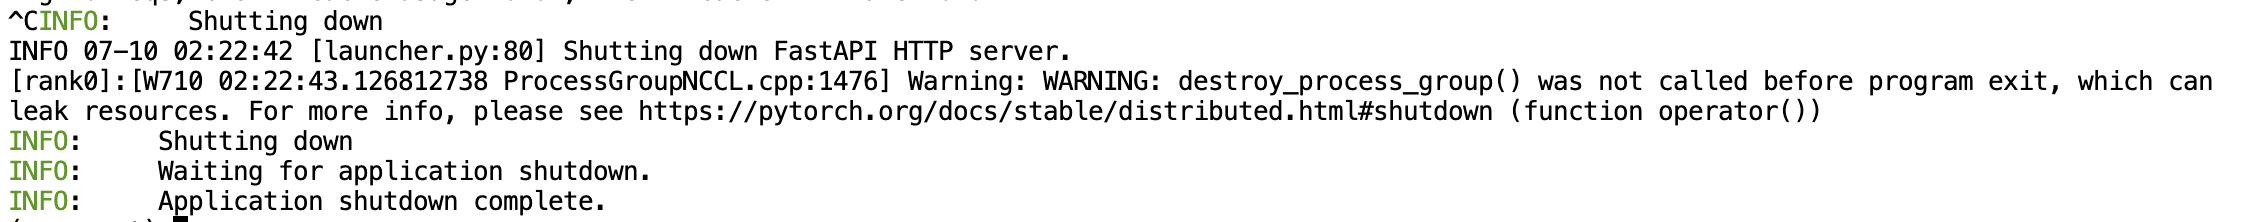

---
This is the end of Lab 1 - Serving a model with vLLM.